# Metrics Study

This notebook will focus on studying the results obtained from the tests done with both QA and QAOA.

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore

## RF distance

In [42]:
# Load the data

rf = pd.read_csv('RF-distance.csv')

rf.head()

,size,id,RF
0,20,10618,41.18
1,20,41388,41.18
2,21,45255,44.44
3,21,48947,27.78
4,22,10240,26.32


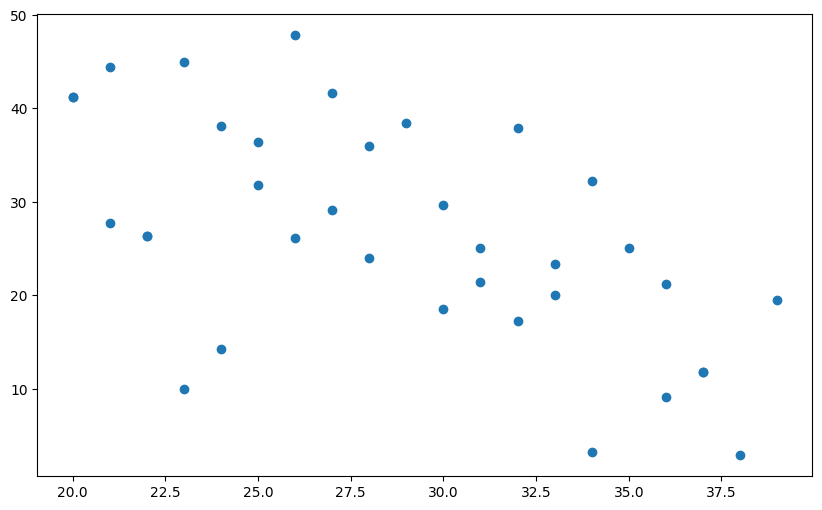

In [31]:
# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(rf['size'], rf['RF'], 'o')

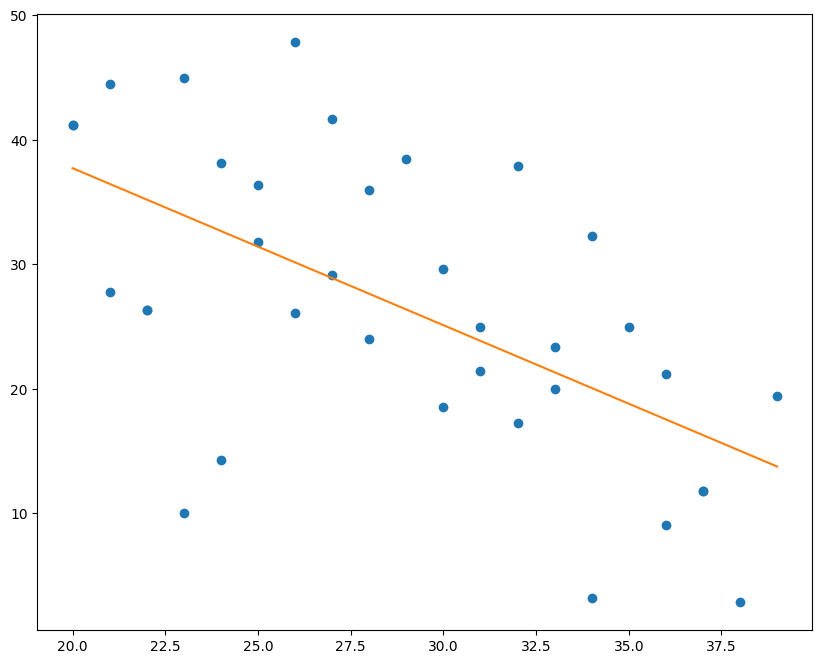

In [16]:
# Create a linear regression model and plot it with the cloud of points

from sklearn.linear_model import LinearRegression

model = LinearRegression()

model.fit(rf[['size']], rf['RF'])

fig,ax = plt.subplots(figsize=(10,8))

ax.plot(rf['size'], rf['RF'], 'o')

y_pred = model.predict(rf[['size']])

ax.plot(rf['size'], y_pred)

plt.show()

Then we can try to explain the outliers by using different tree parameters like average branch length or length of sequence. But first, let's identify outliers.

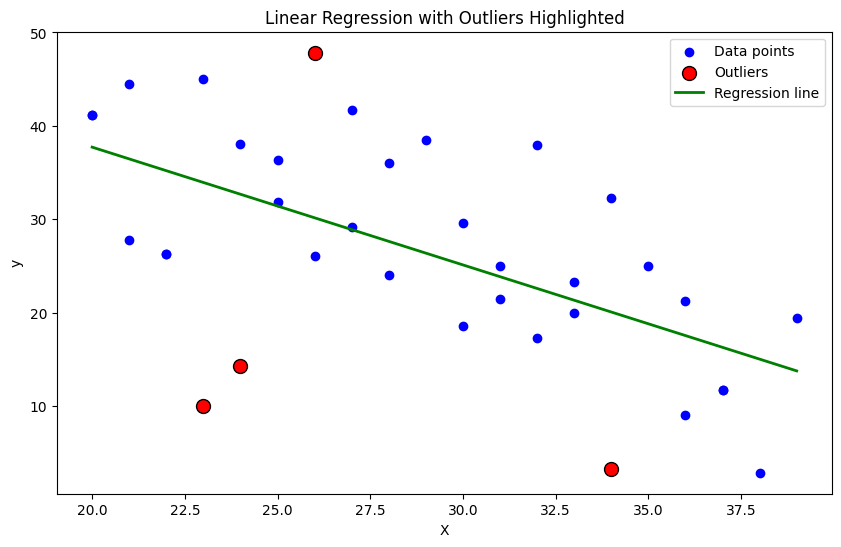

In [25]:
residuals = rf['RF'] - y_pred

# Identify outliers (using z-scores)
threshold = 1.75  # Customize the z-score threshold
outlier_mask = np.abs(zscore(residuals)) > threshold

# Plot the data points and outliers
plt.figure(figsize=(10, 6))
plt.scatter(rf['size'], rf['RF'], label='Data points', color='blue')
plt.scatter(rf['size'][outlier_mask], rf['RF'][outlier_mask], label='Outliers', color='red', edgecolor='k', s=100)
plt.plot(rf['size'], y_pred, label='Regression line', color='green', linewidth=2)
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.title('Linear Regression with Outliers Highlighted')
plt.show()

In [50]:
# Median of all rf
median_rf = rf['RF'].median()
print(f'Median of all RF: {median_rf}')

# Mean of all rf
mean_rf = rf['RF'].mean()
print(f'Mean of all RF: {mean_rf}')

Median of all RF: 26.205
Mean of all RF: 26.547222222222224


## Time

In [28]:
time = pd.read_csv('timer.csv')
time.head()

,size,name,time
0,20,assembled_sequences_10618.fasta,894.84616
1,20,assembled_sequences_41388.fasta,845.65204
2,21,assembled_sequences_45255.fasta,876.65884
3,21,assembled_sequences_48947.fasta,804.53424
4,22,assembled_sequences_10240.fasta,1292.21272


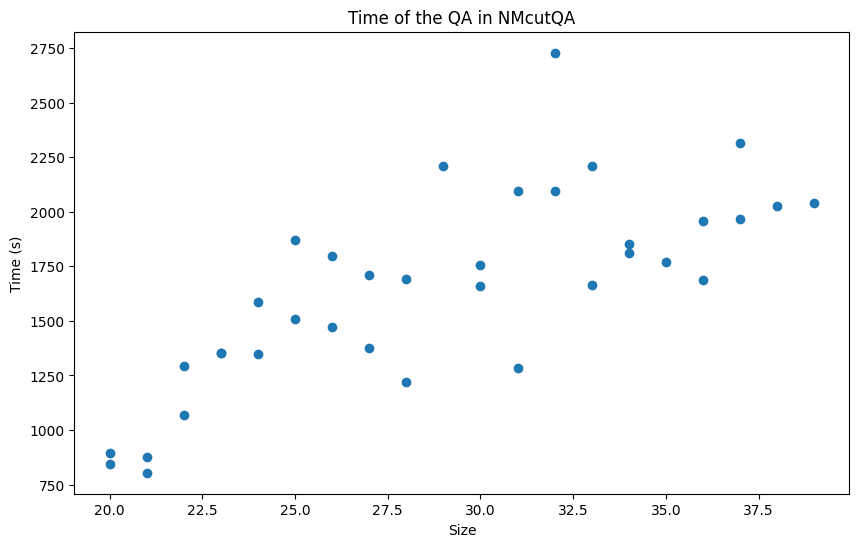

In [35]:
plt.figure(figsize=(10, 6))
plt.plot(time['size'], time['time'], 'o')
plt.xlabel('Size')
plt.ylabel('Time (s)')
plt.title('Time of the QA in NMcutQA')
plt.show()

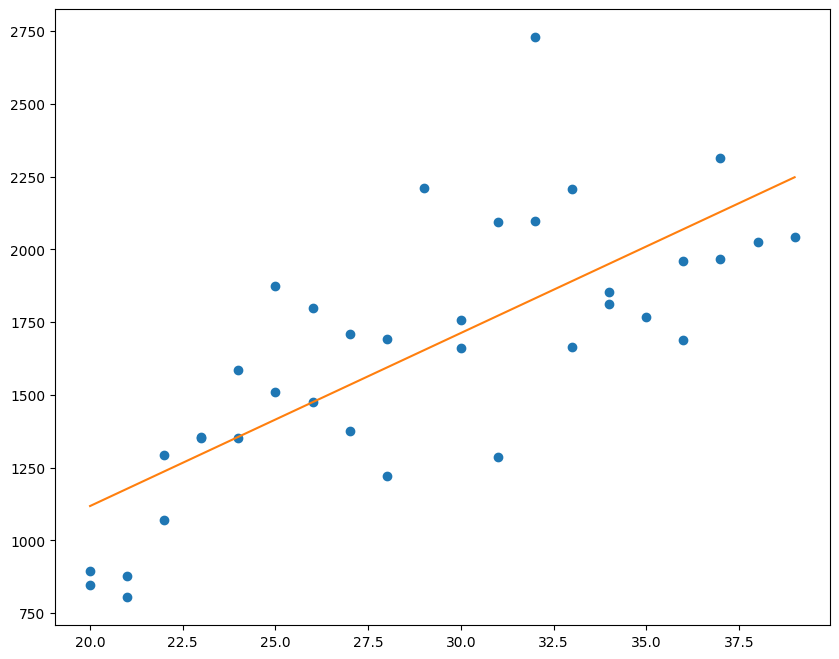

In [36]:
# Seems linear so, linear regression it is

model = LinearRegression()

model.fit(time[['size']], time['time'])

fig,ax = plt.subplots(figsize=(10,8))

X = time['size']
y = time['time']

ax.plot(X, y, 'o')

y_pred = model.predict(rf[['size']])

ax.plot(X, y_pred)

plt.show()

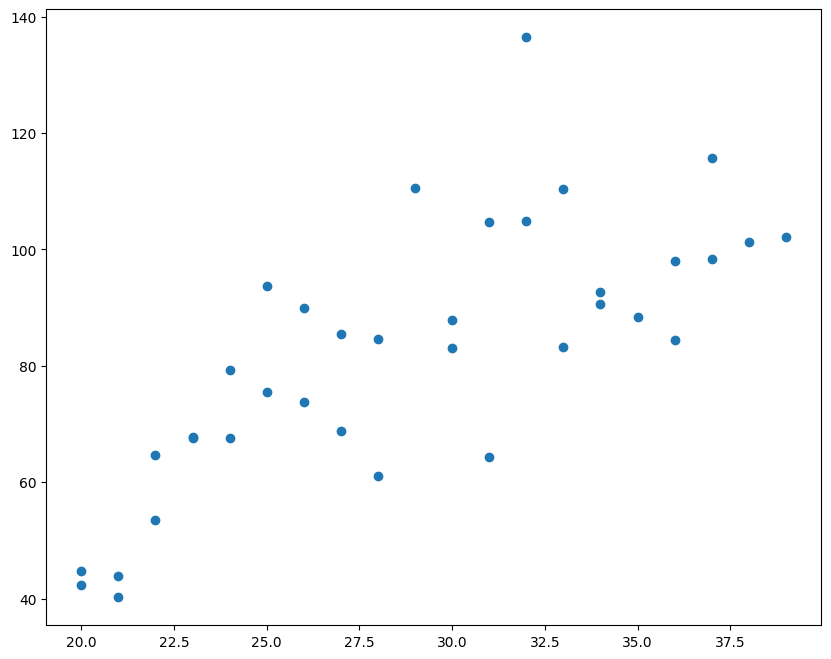

In [47]:
transform_time = time['time']/20

plt.subplots(figsize=(10,8))

plt.plot(time['size'], transform_time, 'o')

